In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from models_classes import (LogRegModel, HidLayerModel)
from losses import cross_entropy_loss
from metrics import accuracy
from utils import (
    _fix_seeds,
    plot_metric_history,
    show_images
)


In [7]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train, X_test = X_train / 255.0, X_test / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


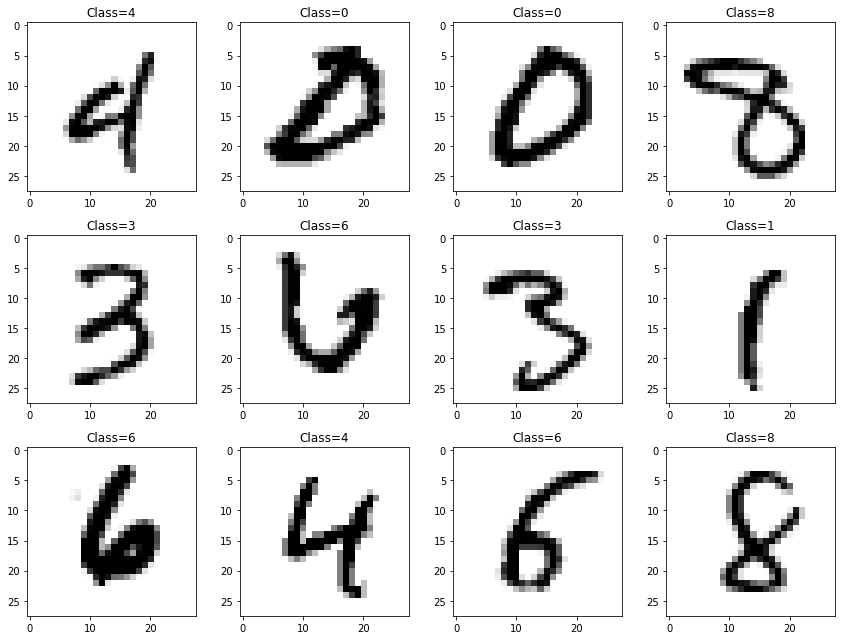

In [8]:
show_images(X_train, y_train, random_sample=True, seed=42, sample_size=12, num_cols=4)

In [9]:
# set constants
_fix_seeds(42)

batch_size = 128
num_steps = 2000
display_step = 100

# define train proces
def train(model, X, y, optimizer):
    """
    One step of train process
    
    params:
        model: model object to train
        X: data
        y: target 
        optimizer: tf optimizer
    return:
        loss_val: loss value
    """
    with tf.GradientTape() as t:
        y_pred = tf.nn.softmax(model(X))
        loss_val = cross_entropy_loss(y, y_pred)
        
    grads = t.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    acc = accuracy(y, y_pred)
    
    return loss_val, acc

# define evaluate proces
def evaluate(model, X, y):
    """
    One step of evaluation process
    
    params:
        model: model object to evaluate
        X: data to evaluate
        y: target 
    return:
        loss_val: loss value
    """
    y_pred = tf.nn.softmax(model(X))
    loss_val = cross_entropy_loss(y, y_pred)
    
    acc = accuracy(y, y_pred)
    
    return loss_val, acc

In [19]:
# Initialize weigts 
W = tf.Variable(tf.random.normal([784, 10], dtype='float32'), name='weights')
b = tf.Variable(tf.zeros([10], dtype='float32'), name='biases')

# Set up model and optimier
model = LogRegModel(W, b)
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

# collect metrics
loss_history = {
    'train': [],
    'test': []
}
acc_history = {
    'train': [],
    'test': []
}

# running optimization
for i in range(num_steps):
    
    # select train data batch
    indices = np.random.choice(len(X_train), batch_size)
    X_train_batch, y_train_batch = X_train[indices], y_train[indices]
    
    # Flatten data and make ohe over target
    X_train_batch_flat = tf.cast(X_train_batch.reshape(batch_size, 784), tf.float32)
    y_train_batch_ohe = tf.cast(tf.one_hot(y_train_batch, 10), tf.float32)
    
    # train model
    train_loss, train_acc = train(model, X_train_batch_flat, y_train_batch_ohe, optimizer)
    
    # select test data batch
    indices = np.random.choice(len(X_test), batch_size)
    X_test_batch, y_test_batch = X_test[indices], y_test[indices]
    
     # Flatten data and make ohe over target
    X_test_batch_flat = tf.cast(X_test_batch.reshape(batch_size, 784), tf.float32)
    y_test_batch_ohe = tf.cast(tf.one_hot(y_test_batch, 10), tf.float32)    
    
    # evaluate model
    test_loss, test_acc = evaluate(model, X_test_batch_flat, y_test_batch_ohe)
    
    # collect current metrics
    loss_history['train'].append(train_loss.numpy())
    loss_history['test'].append(test_loss.numpy())
    acc_history['train'].append(train_acc)
    acc_history['test'].append(test_acc)
    
    # output info
    if (i+1) % display_step == 0:
        print(f'Epoch {i+1}: train loss={train_loss.numpy()}, train acc={train_acc}')
        print(f'\t\ttest loss={test_loss.numpy()}, test acc={test_acc}\n')

Epoch 100: train loss=-0.3421470522880554, train acc=0.5078125
		test loss=-0.3336945176124573, test acc=0.4765625

Epoch 200: train loss=-0.35601818561553955, train acc=0.515625
		test loss=-0.3797864317893982, test acc=0.53125

Epoch 300: train loss=-0.34543377161026, train acc=0.5078125
		test loss=-0.38711121678352356, test acc=0.5546875

Epoch 400: train loss=-0.3747445344924927, train acc=0.53125
		test loss=-0.46813422441482544, test acc=0.671875

Epoch 500: train loss=-0.48676449060440063, train acc=0.703125
		test loss=-0.49814704060554504, test acc=0.71875

Epoch 600: train loss=-0.5022050142288208, train acc=0.7265625
		test loss=-0.47584766149520874, test acc=0.6875

Epoch 700: train loss=-0.48978185653686523, train acc=0.7109375
		test loss=-0.5055556297302246, test acc=0.7265625

Epoch 800: train loss=-0.46974021196365356, train acc=0.6796875
		test loss=-0.5387479066848755, test acc=0.7734375

Epoch 900: train loss=-0.4654000997543335, train acc=0.671875
		test loss=-0.5

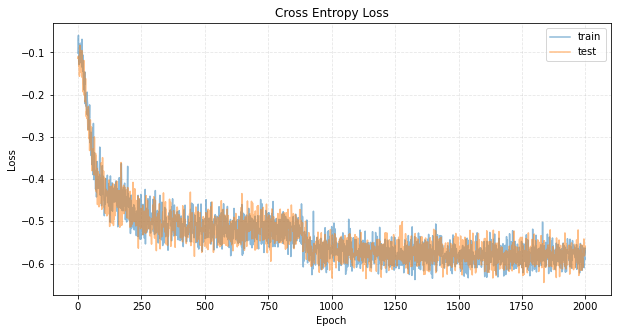

In [11]:
plot_metric_history(loss_history, title='Cross Entropy Loss')

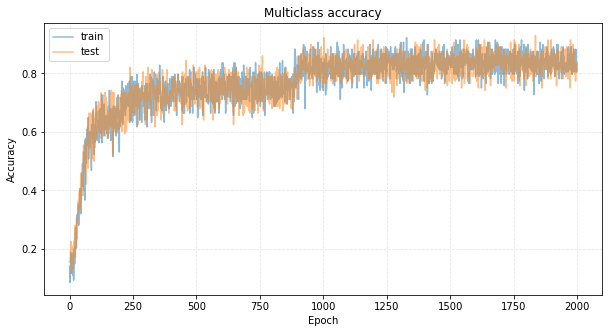

In [12]:
plot_metric_history(acc_history, title='Multiclass accuracy', ylabel='Accuracy')

### Model with hidden layer (relu)

In [15]:
_fix_seeds(42)
# weights
W_relu = tf.Variable(tf.random.normal([784, 100], dtype='float32', stddev=0.1), name='weights1')
b_relu = tf.Variable(tf.zeros([100], dtype='float32',), name='biases1')
W_logit = tf.Variable(tf.random.normal([100, 10], dtype='float32'), name='weights2')
b_logit = tf.Variable(tf.zeros([10], dtype='float32'), name='biases2')

#model
model = HidLayerModel(W_relu, b_relu, W_logit, b_logit)
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

#collect metrics
loss_history = {
    'train': [],
    'test': []
}
acc_history = {
    'train': [],
    'test': []
}

#running optimization
for i in range(num_steps):
    indices = np.random.choice(len(X_train), batch_size)
    X_train_batch, y_train_batch = X_train[indices], y_train[indices]
    
    X_train_batch_flat = tf.cast(X_train_batch.reshape(batch_size, 784), tf.float32)
    y_train_batch_ohe = tf.cast(tf.one_hot(y_train_batch, 10), tf.float32)
    
    # train model
    train_loss, train_acc = train(model, X_train_batch_flat, y_train_batch_ohe, optimizer)

    # select test data batch
    indices = np.random.choice(len(X_test), batch_size)
    X_test_batch, y_test_batch = X_test[indices], y_test[indices]
    
    # Flatten data and make ohe over target
    X_test_batch_flat = tf.cast(X_test_batch.reshape(batch_size, 784), tf.float32)
    y_test_batch_ohe = tf.cast(tf.one_hot(y_test_batch, 10), tf.float32)    
    
    # evaluate model
    test_loss, test_acc = evaluate(model, X_test_batch_flat, y_test_batch_ohe)
    
    # collect current metrics
    loss_history['train'].append(train_loss.numpy())
    loss_history['test'].append(test_loss.numpy())
    acc_history['train'].append(train_acc)
    acc_history['test'].append(test_acc)
    
    # output info
    if (i+1) % display_step == 0:
        print(f'Epoch {i+1}: train loss={train_loss.numpy()}, train acc={train_acc}')
        print(f'\t\ttest loss={test_loss.numpy()}, test acc={test_acc}\n')








Epoch 100: train loss=-0.33547288179397583, train acc=0.484375
		test loss=-0.42420557141304016, test acc=0.609375

Epoch 200: train loss=-0.44521331787109375, train acc=0.640625
		test loss=-0.4596126675605774, test acc=0.6640625

Epoch 300: train loss=-0.5065900087356567, train acc=0.734375
		test loss=-0.4811244010925293, test acc=0.6953125

Epoch 400: train loss=-0.48139488697052, train acc=0.6953125
		test loss=-0.5471135377883911, test acc=0.7890625

Epoch 500: train loss=-0.5274282693862915, train acc=0.7578125
		test loss=-0.5251976251602173, test acc=0.7578125

Epoch 600: train loss=-0.5262596011161804, train acc=0.7578125
		test loss=-0.5230123996734619, test acc=0.75

Epoch 700: train loss=-0.5451842546463013, train acc=0.7890625
		test loss=-0.5241063833236694, test acc=0.75

Epoch 800: train loss=-0.5974788665771484, train acc=0.859375
		test loss=-0.5967788696289062, test acc=0.859375

Epoch 900: train loss=-0.6304868459701538, train acc=0.9140625
		test loss=-0.565469503